
# Clasificación Lineal y Evaluación del Desempeño

Definimos primero unas librerías y funciones que vamos a usar a durante la sesión:

In [1]:
!pip install tabulate

In [0]:
%matplotlib inline
import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns; sns.set()
from sklearn import preprocessing
from sklearn import datasets


In [0]:
def plot_data(X, y):   #Función para graficar datos (X,y)
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

In [0]:
def plot_decision_region(X, pred_fun):      #Función para visualizar la superficie de decisión de nuestro algoritmo.
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

In [0]:
def list_cm(cm,classes):     #función para generar de una forma más visual la matriz de confusión
    if len(cm)==2:
      row_0 =['','Valor','Verdadero']
      row_1 =['-',classes[0],classes[1]]
      row_2 =[classes[0],cm[0,0],cm[1,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1]]
      table = zip(row_0,row_1, row_2, row_3)
      headers = ['', '', 'Valor', 'Predicho']  
      return print(tabulate(table, headers=headers, floatfmt=".4f"))
    else:
      row_0 =['','Valor','Verdadero','']
      row_1 =['-',classes[0],classes[1],classes[2]]
      row_2 =[classes[0],cm[0,0],cm[1,0],cm[2,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1],cm[2,1]]
      row_4 =[classes[2],cm[0,2],cm[1,2],cm[2,2]]
      table = zip(row_0,row_1, row_2, row_3, row_4)
      headers = ['', '', 'Valor', 'Predicho', '']  
      return print(tabulate(table, headers=headers, floatfmt=".4f"))   

# Regresión logística

La regresión logística es un modelo lineal para clasificación. Es conocida también como regresión logit o clasificador de máxima entropía. Dado un vector de características $x$ para un ejemplo concreto, tenemos que:

* Podemos establecer una función de predicción $f:\mathbb{R}^{2}\rightarrow\mathbb{R}$ tal que:

$$\textrm{Prediction}(x)=\begin{cases}
C_{1} & \mbox{si }f(x)\ge \theta\\
C_{2} & \mbox{si }f(x)<\theta
\end{cases}$$

* Usaremos una función $f$ como un modelo logístico de los parámetros $w$ y $w_0$:

$$f_w(x) = P(C_1|x)= \sigma(wx+w_0)$$

donde
$$\sigma(x) = \frac{1}{1+e^{-x}}$$

* La función logística se comporta de la siguiente manera:

<img src="https://drive.google.com/uc?export=view&id=1aOQjJBQfvs_3e6d1WX_jPFD51-EAqWxn">
Figure:logistic2.svg

El objetivo del modelo consiste en ajustar los coeficientes de $f$ con el objetivo de predecir de forma correcta la clase de cada ejemplo

## Conjunto de datos

Usamos la función `make_blobs` de scikit learn para generar un conjunto de datos sintéticos:

In [6]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)
print(X.shape)
print(y.shape)
y

(100, 2)
(100,)


array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1])

Graficamos los datos generados artificialmente como sigue:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


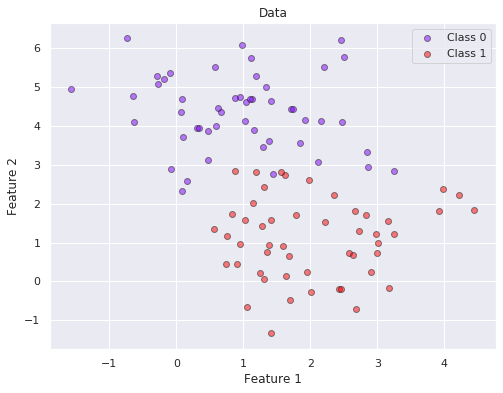

In [7]:
pl.figure(figsize=(8, 6))
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')
plot_data(X, y)

## Entrenamiento de un modelo  LogisticRegression usando Scikit-Learn


<img src="https://drive.google.com/uc?export=view&id=1nnjm7QQh-uIFcPpn0NjQ8EIbYR4Meji2">
Figure:Scikit-learn.svg

Todos los modelos de clasificación soportados por Scikit-Learn siguen el flujo de trabajo presentado en el gráfico anterior. Durante la sesión vamos a trabajar en la parte de entrenamiento y predicción. En la siguiente sesión se completará el flujo de trabajo revisando la parte de generalización. Scikit-Learn nos permite entrenar modelos de predicción automática a través de un API muy consistente. La implementación de regresión logística se encuentra usando `sklearn.linear_model.LogisticRegression`.

In [0]:
from sklearn.linear_model import LogisticRegression

Primero creamos un modelo de tipo `LogisticRegression`

In [0]:
classifier = LogisticRegression()
cl2 = LogisticRegression(C=1.5)

Para construír el modelo a partir de nuestros datos, se hace un llamado a la función `fit()` usando los datos de entrenamiento. `fit()` recibe como parámetros la matriz de características y las etiquetas del conjunto de datos.

In [10]:
classifier.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Si se desean conocer los parámetros del estimador que se está entrenando, podemos llamar la función `classifier.get_params()`.

In [11]:
classifier.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Explicación de los parámetros:

A continuación, presentamos una descripción de los ṕarámetros más importantes del modelo de regresión logística usando Scikit-Learn:

* $C$: parámetro de regularización. Aunque el concepto de sobreajuste se verá en la siguiente sesión, $C$ penaliza los modelos que se ajusten demasiado al conjunto de datos.
* $class\_weight$: En caso de que el problema de clasificación sea desbalanceado, es decir, existen más elementos de una clase que de la otra, se puede dar mayor peso a aquellas muestras provenientes de la clase de menor número de ejemplos.
* $n\_jobs$: Número de procesos a usar para paralelizar el proceso de entrenamiento. -1 Usa todos los procesadores disponibles menos 1.
* $solver$: `{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}`. Este parámetro corresponde al algoritmo usado para la optimización. La implementación de `liblinear` se encuentra escrita en C++ y es una de las más usadas. `sag` y `saga` recaen en una implementación de gradiente descendente conocida como `Stochastic Average Gradient`.

Para la fase de predicción, basta con llamar `predict()`.

In [12]:
classifier.predict(X)

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1])

Para la fase de evaluación, basta con llamar `score()`.

In [13]:
classifier.score(X, y)

0.92

A continuación, encontramos la superficie de decisión. En este caso de clasificación de dos clases, `LogisticRegression` regresa una predicción que puede ser $1$ o $-1$.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


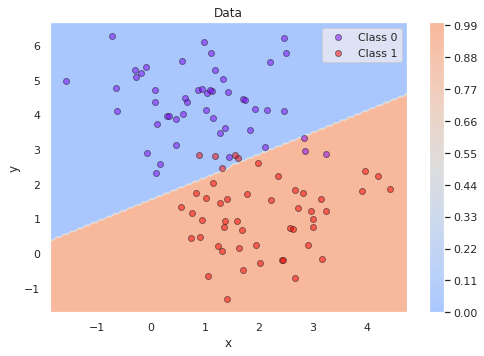

In [14]:
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, gen_pred_fun(classifier))
plot_data(X, y)

# Clasificación Bayesiana

Los clasificadores Naive Bayes están basados en métodos de clasificación bayesiana. Es decir, son basados en el teorema de Bayes, el cual  describe la relación de las probabilidades condicionales de cantidades estadísticas. En este caso, queremos estimar la probabilidad de que un ejemplo con características $x=(x_1, x_2, \dots, x_n)$ pertenezca a una clase dada  **C**: $P (C | x_1, x_2, \dots, x_n)$. 

A través del teorema de Bayes se puede expresar en términos de cantidades que podemos calcular más directamente:

$$P (C | x_1, x_2, \dots, x_n) =\frac{P( x_1, x_2, \dots, x_n | C)P(C)}{P( x_1, x_2, \dots, x_n)}$$

* Si estamos tratando de decidir entre dos clase, llamadas $C_1$ y $C_2$, escogemos la clase con la mayor probabilidad. Por ejemplo si 

$$P (C_1 | x_1, x_2, \dots, x_n) \ge P (C_2 | x_1, x_2, \dots, x_n)$$

la predicción más razonable es $C_1$.

El clasificador Naive Bayes (o clasificador bayesiano ingenuo) hace una suposición fuerte: que las características son condicionalmente independientes dada la clase. Es decir:
$$ P( x_1, x_2, \dots, x_n | C) =P(x_1 | C)P(x_2 | C)\dots P(x_n | C)$$  

##Clasificador Gausiano Naive Bayes

Graficamos de nuevo los datos usados en el clasificador anterior:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


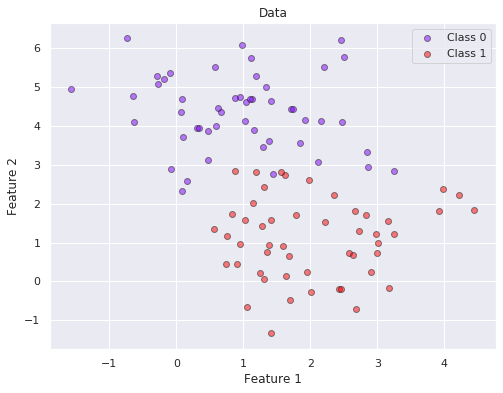

In [15]:
pl.figure(figsize=(8, 6))
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')
plot_data(X, y)

Una forma extremadamente rápida de crear un modelo simple es suponer que los datos se describen mediante una distribución gaussiana sin covarianza entre las dimensiones. Este procedimiento se implementa en Scikit-Learn's usando **sklearn.naive_bayes.GaussianNB estimator**:

In [0]:
from sklearn.naive_bayes import GaussianNB
classifier2 = GaussianNB()
classifier2.fit(X, y);

Ahora generemos algunos datos nuevos y pronosticamos la clase a la que pertenece, como sigue:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


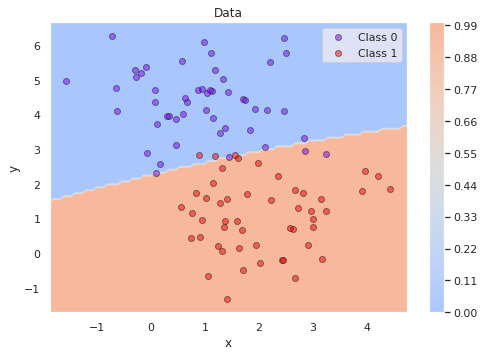

In [17]:
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, gen_pred_fun(classifier2))
plot_data(X, y)

Vemos un límite ligeramente curvo en las clasificaciones; en general, el límite en el clasificador Gausiano Naive Bayes es cuadrático.  Si queremos saber la probabilidad de cada elemento de ser clasificado en una clase dada, podemos calcularlo fácilmente utilizando el método de **predict_proba**:

In [18]:
classifier2.score(X,y)

0.95

In [19]:
yprob = classifier2.predict_proba(X)
yprob[-8:].round(2)

array([[0.11, 0.89],
       [0.  , 1.  ],
       [0.97, 0.03],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.06, 0.94]])

Evaluando nuestro clasificador para compararlo con el anterior obtenemos:

In [20]:
classifier2.score(X, y)

0.95

# Clasificación del conjunto de datos IRIS:

## Carga de datos para Scikit-Learn

Los datos en Scikit-Learn se asume que están almacenados en un arreglo de dos dimensiones, cuyo tamaño es [n_muestras, n_características]. Aunque muchos de los algoritmos de Scikit reciben [matrices sparse](http://www.scipy-lectures.org/advanced/scipy_sparse/index.html) de SciPy del mismo tamaño.

- `n_muestras`: El número de muestras. Cada muestra es un item a procesar, en este caso a clasificar. Una muestra consiste en una imagen, un documento, un video, una fila en una base de datos.
- `n_características`: El número de características o rasgos que son usados para describir cada item de forma cuantitativa. Estas características son por lo general valores continuos, aunque también pueden ser boleanos o valores discretos.

El número de características es establecido de antemano, inclusive pueden ser de una alta dimensionalidad. En resumen, en el arreglo de dos dimensiones cada fila corresponderá a un ejemplo del conjunto de datos y cada columna corresponderá a una característica asociada.

## Conjunto de datos IRIS.

In [0]:
iris = datasets.load_iris()

Podemos observar que contiene este objeto que nos regresa scikit-learn usando `keys()`

In [22]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [23]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

* `data`: Contiene la matriz de datos descrita en la sección anterior. 
* `target`: Las etiquetas de cada uno de las instancias del conjunto de datos (Filas de la matriz).
* `target_names`: Son los nombres asociados a las etiquetas.
* `feature_names`: Nombres de las características asociadas.

Encontramos que el número de muestras y características de `data` es:

In [24]:
n_samples, n_features = iris.data.shape
print('Número de muestras:', n_samples)
print('Número de características:', n_features)

Número de muestras: 150
Número de características: 4


Observamos que cada fila corresponde a un ejemplar de una especie de flor. Cada flor tiene asociado una serie de características, como el ancho y largo del sépalo, y el ancho y largo del pétalo.

<img src="https://drive.google.com/uc?export=view&id=1TB-7jzOkgnA-EAnDFWJgIzyb0fbY89XH">
Figure: iris_petal_sepal.png

Podemos inspeccionar de forma manual las características del último elemento del conjunto de datos:

In [25]:
print(list(zip(iris.feature_names, iris.data[-1])))

[('sepal length (cm)', 5.9), ('sepal width (cm)', 3.0), ('petal length (cm)', 5.1), ('petal width (cm)', 1.8)]


Verificamos que `iris.target` sea del mismo tamaño que el número de muestras en `iris.data`

In [26]:
print(iris.target.shape)

(150,)


Las especies que tratamos de predecir son:

In [27]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


La distribución de elementos por etiqueta está distribuída en el conjunto de datos, es decir, existe el mismo número de flores por especie:

In [28]:
print(list(zip(iris.target_names, np.bincount(iris.target))))

[('setosa', 50), ('versicolor', 50), ('virginica', 50)]


### Visualización usando Pandas

La función `scatter_matrix` de Pandas nos permite visualizar cada elemento del conjunto de datos como una comparación entre características:
* Largo del sépalo (cm)
* Ancho del sépalo (cm)
* Largo del pétalo (cm)
* Ancho del pétalo (cm)

A continuación comparamos cada pareja de características usando `scatter_matrix`:

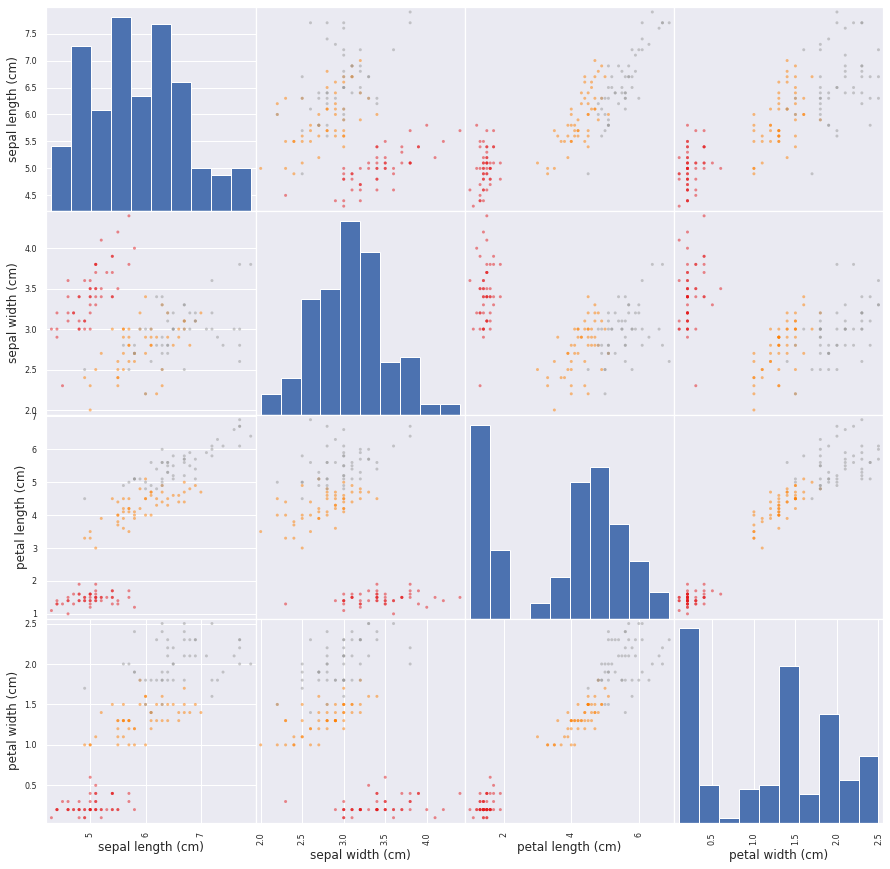

In [29]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
pd.plotting.scatter_matrix(iris_df, c=iris.target, cmap='Set1', figsize=(15, 15));

Encontramos que la clase representada de color rojo, es la clase Iris Setosa.

## Clasificación binaria usando Scikit-Learn

Ahora que conocemos el conjunto de datos IRIS, queremos entrenar un modelo que sea capaz de clasificar de forma automática cualquier flor representada en un conjunto de datos (Ancho del pétalo (cm), largo del sépalo (cm)', largo del pétalo (cm)', ancho del pétalo (cm)). Como en la demo anterior, filtramos aquellas flores que pertenezcan a la clase versicolor y virginica. Para verificar qué columnas corresponde al largo del sépalo y al ancho del pétalo, imprimimos `feature_names`

In [30]:
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [0]:
X = iris.data[:,[0, 3]] # Columna 0: Largo del sépalo, Columna 3: Ancho del pétalo
y = iris.target

X = X[(y == 1) | (y == 2)] # Filtramos la clase 1 y 2 que corresponden a versicolor y virginica.
y = y[(y == 1) | (y == 2)] 

y = y - 1 # Para que las clases queden entre 0 y 1

In [32]:
y.shape

(100,)

Entrenamos el modelo `LogisticRegression` y verificamos los valores predichos. `LogisticRegression` es un modelo lineal, lo que significa que creará una decisión que es lineal en el espacio de entrada. Es decir, encuentra una linea que separa los datos.

In [33]:
classifier = LogisticRegression()
classifier.fit(X, y)
predictions = classifier.predict(X)

print('Número de instancias a predecir: {}'.format(y.shape[0]))
print('Valores de verdad: {}'.format(y))
print('Valores predichos: {}'.format(predictions))

Número de instancias a predecir: 100
Valores de verdad: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valores predichos: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Pregunta**
* ¿Cómo evaluamos el desempeño de nuestro clasificador?

# Evaluación del desempeño - Clasificación binaria

Con el objetivo de conocer el desempeño de nuestro clasificador, se mide cuantitativamente cuántas predicciones fueron correctas. Este número se conoce como **exactitud** o **accuracy** en inglés.

In [57]:
prediction = classifier.predict(X)
np.mean(prediction == y)

0.42

Scikit nos permite evaluar también el accuracy con la función `.score()`

In [58]:
classifier.score(X, y)

0.42

### Matriz de confusión

Sin embargo, es deseable conocer qué clases clasifica mejor. Para poder visualizar esta información, usaremos la matriz de confusión, la cual es una clase especial de tabla de contingencia en la cual se comparan las clases reales contra las clases predichas por el clasificador. Scikit-Learn nos permite construír la matriz de confusión usando `sklearn.metrics.confusion_matrix`. `confusion_matrix` recibe como argumento dos listas o arreglos de NumPy:
* $y$: Etiquetas reales del conjunto de datos
* $\hat{y}$: Etiquetas predichas por el clasificador sobre el conjunto de datos

In [0]:
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
prediction = classifier.predict(X)
cnf_matrix = confusion_matrix(y, prediction)

`confusion_matrix` regresa una matriz de tamaño [$\textit{n_clases}$, $\textit{n_clases}$], dónde $\textit{n_clases}$ corresponde al número de clases únicas en el conjunto de datos. La matriz de confusión nos permite comparar el rendimiento de nuestro clasificador clase por clase.

In [60]:
print(cnf_matrix)

[[13 37  0]
 [ 0 50  0]
 [ 0 50  0]]


A continuación, vamos a usar la función definida al comienzo para generar de una forma más visual la matriz de confusión

In [61]:
class_names = iris.target_names[1:]
list_cm(cnf_matrix,class_names)

IndexError: ignored

### **¿Cómo interpretarla?**

* Los valores en la diagonal indican los aciertos de nuestro clasificador. Por ejemplo, sabemos que de 50 ejemplos de la clase versicolor, supo clasificar 46. Mientras que de 50 ejemplos de la clase virginica, se equivocó en 6.
* El accuracy y el error pueden ser a su vez definidos desde la matriz de confusión:

In [62]:
acc = np.sum([cnf_matrix[i, i] for i in range(cnf_matrix.shape[0])])/np.sum(cnf_matrix)

print('Accuracy: {}'.format(acc))

Accuracy: 0.42


In [63]:
err = np.sum([cnf_matrix[0, 1], cnf_matrix[1, 0]])/np.sum(cnf_matrix)

print('Error: {}'.format(err))

Error: 0.24666666666666667


### ¿Qué pasa cuando el problema es imbalanceado?

Supongamos un clasificador $G$ con el siguiente desempeño sobre un conjunto de datos:

* $Accuracy = \frac{99}{100} = 99\%$  
* $Error = \frac{1}{100} = 1\%$  

**¿Es un buen clasificador?**

Para medir efectivamente si $G$ es un buen clasificador, presentamos la matriz de confusión producto de sus predicciones.

In [64]:
class_names = ['C_+', 'C_-']
y_pred = np.ones(100)
y_test = np.ones(100)
y_test[-1] = 0
mat = confusion_matrix(y_test, y_pred)
list_cm(mat,class_names)

                Valor    Predicho
---------  ---  -------  ----------
           -    C_+      C_-
Valor      C_+  0        1
Verdadero  C_-  0        99


A pesar de que el modelo clasificó correctamente 99 muestras de la clase negativa, falló en clasificar la única muestra positiva del conjunto de datos.

### Precisión, Recall y F1 
La matriz de confusión nos permite calcular otra serie de medidas para evaluar el desempeño del clasificador. Para introducir estas medidas, vamos a descomponer la matriz de confusión en cuatro partes:

<img src="https://drive.google.com/uc?export=view&id=1NwaZST2l_A8ohWZCdYt15zXq3rP0dbrw">


Los componentes de esta matriz pueden interpretarse como:
* TP: Verdaderos positivos. Resultado correcto para la clase positiva.
* TN: Verdaderos negativos. Ausencia correcta para la clase positiva.
* FP: Falsos positivos. Resultados inesperados.
* FN: Falsos negativos. Resultados faltantes.

Vale la pena aclarar que en clasificación binaria, los terminos *positivo* o *negativo* se refieren a la predicción del clasificador (Clase), mientras que *verdadero* o *falso* se refieren a si la predicción fue correcta o no.

De esta matriz podemos volver a escribir las definiciones de accuracy y error:
* $accuracy = \frac{TP + TN}{TP + FN + FP + TN}$
* $error = \frac{FP + FN}{TP + FN + FP + TN}$  

Así como las definiciones de precisión, recall y f1 score:

* $PRE = \frac{TP}{TP + FP}$ 
* $REC = \frac{TP}{FN + TP}$ 
* $F_1 = 2 * \frac{PRE*REC}{PRE + REC}$

La precisión se puede definir como la habilidad del clasificador de **no** clasificar una muestra como positiva cuando es negativa. Mientras el recall (índice de recuperación) se puede definir como la capacidad del clasificador de encontrar todas las muestras positivas. $F_1 \textit{score}$ se define como el promedio pesado de precisión y recall. Evaluemos la precision y el índice de recuperación de nuestro clasificador $G$:

* $PRE = \frac{0}{0}$ = No definida
* $REC = \frac{0}{1} = 0\%$ Recall

Scikit-learn provee diferentes funciones para calcular estas tres medidas. Vamos a medir el desempeño sobre el clasificador $G$

In [65]:
from sklearn import metrics

print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, pos_label=0 )))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred,  pos_label=0)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, y_pred,  pos_label=0)))

Precision: 0.0
Recall: 0.0
F_1 score: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


El parámetro `pos_label` indica cual etiqueta corresponde a la clase positiva. Para nuestro ejemplo hemos tomado la clase $0$ como la clase positiva. Por otro lado, el `Warning` generado por Scikit-Learn corresponde a que la medida no se pudo calcular de forma correcta, por la presencia de un denominador en $0$, por lo tanto se le asigna $0$ a la medida. Estas medidas nos indican que el clasificador $G$ no es la mejor opción para resolver el problema. 

### Precisión, recall y F1 sobre IRIS
Regresando al problema de clasificación binario sobre IRIS, podemos calcular precision, recall y F1 de la misma manera:

In [0]:
print('Precision: {}'.format(metrics.precision_score(y, prediction)))
print('Recall: {}'.format(metrics.recall_score(y, prediction)))
print('F_1 score: {}'.format(metrics.f1_score(y, prediction)))

## Clasificación multiclase

**¿Cómo extender a una solución que involucre más de dos clases?**

Existen dos soluciones:
* Uno contra el resto (One vs All). Para esto, seguimos los siguientes pasos:
    * Construímos un clasificador usando regresión logística $h_\theta^{(i)} (x)$ para cada clase $i$, en el cual se trata de predecir la probabilidad de que $y=i$
    * Cuando llegue un nuevo ejemplo $x$, escogemos lo clase $i$ que maximize: 
$$\max_{i} h_\theta^{(i)} (x)$$

<img src="https://drive.google.com/uc?export=view&id=1WhINPmEOyH3ClCtmuPL9TogOan31k7Tk">

Fuente: https://www.coursera.org/learn/machine-learning/lecture/68Pol/multiclass-classification-one-vs-all

Para indicar que la estrategia de clasificación multiclase es "*One vs Rest*", modificamos el parámetro `multi_class` en el llamado a `LogisticRegression()`.

In [68]:
X = iris.data[:,[0, 2]] 
y = iris.target

classifier_ovr = LogisticRegression(multi_class='ovr')
classifier_ovr.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

A continuación visualizamos la función de decisión para el problema multiclase.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


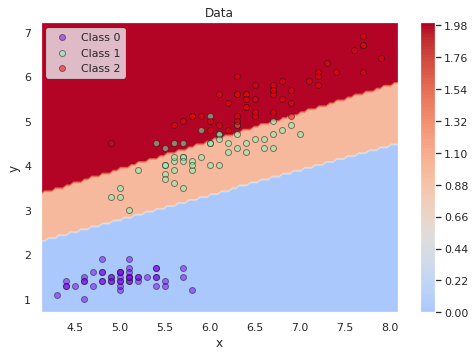

In [69]:
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, gen_pred_fun(classifier_ovr))
plot_data(X, y)

* Regresión logística multinomial:
    La función logística se puede generalizar para que aprenda una distribución de probabilidad sobre todas las clases. Esta función se conoce como función **SoftMax**. Para esto, $P(y=i\mid \mathbf {x} )$ se puede escribir así:
$$P(y=i\mid \mathbf {x} )={\frac {e^{\mathbf {x} ^{\mathsf {T}}\mathbf {w} _{i}}}{\sum _{k=1}^{K}e^{\mathbf {x} ^{\mathsf {T}}\mathbf {w} _{k}}}}$$
dónde $x$ corresponde a mi vector de características, $K$ al número de clases y $w$ a los coeficientes de la función $wx + w_0$ para la clase $i$.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


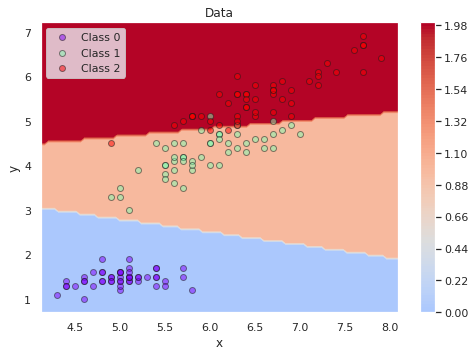

In [70]:
classifier_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs');
classifier_multi.fit(X, y)

pl.figure(figsize = (8,16/3))    
plot_decision_region(X, gen_pred_fun(classifier_multi))
plot_data(X, y)

## Evaluación del desempeño - Caso multiclase

La matriz de confusión se puede extender al problema multiclase de la siguiente manera:

### Matriz de confusión en el caso multiclase

Primero, visualizaremos la matriz de confusión para el modelo de regresión logística multinomial

In [71]:
class_names = iris.target_names
y_pred = classifier_multi.predict(X)
mat = confusion_matrix(y, y_pred)
list_cm(mat,class_names)

                       Valor    Predicho
---------  ----------  -------  ----------  ---------
           -           setosa   versicolor  virginica
Valor      setosa      50       0           0
Verdadero  versicolor  0        47          3
           virginica   0        3           47


Ahora calculamos la matriz de confusión para el método de regresión logística usando la estrategia "*Uno contra todos*"

In [72]:
class_names = iris.target_names
y_pred = classifier_ovr.predict(X)
mat = confusion_matrix(y, y_pred)
list_cm(mat,class_names)

                       Valor    Predicho
---------  ----------  -------  ----------  ---------
           -           setosa   versicolor  virginica
Valor      setosa      50       0           0
Verdadero  versicolor  0        40          10
           virginica   0        1           49


A simple vista podemos mencionar que:
* La clase *setosa* es fácil de clasificar para ambos clasificadores.
* Aunque el modelo usando "*Uno contra Todos*" tiene mejor desempeño en la clase *virginica*, tiene un pésimo desempeño en la clase *versicolor*, con respecto al modelo usando regresión logística multinomial.

De nuevo, es útil usar una medida de desempeño para comparar cuantitativamente el rendimiento de ambos modelos.

### Accuracy multiclase

El accuracy multiclase se define como la fracción de predicciones correctas del clasificador. Se puede calcular de la siguiente formula:

$$
\texttt{acc}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} 1(\hat{y}_i = y_i)
$$

dónde $y$ corresponde a la lista de etiquetas de verdad de nuestro conjunto de datos, mientras $\hat{y}$ corresponde a los valores predichos por nuestro clasificador para el mismo conjunto de datos y **en el mismo orden**. $n$ corresponde al número de ejemplo del conjunto. Scikit-Learn nos permite calcular el accuracy de la misma manera:

In [49]:
print('Accuracy OVR classifier: {}'.format(classifier_ovr.score(X, y)))
print('Accuracy Multinomial classifier: {}'.format(classifier_multi.score(X, y)))

Accuracy OVR classifier: 0.9266666666666666
Accuracy Multinomial classifier: 0.96


El modelo de regresión logística se desempeña mejor frente al modelo "*Uno vs Todos*". El error se puede definir como la fracción de predicciones incorrectas del clasificador:

In [73]:
print('Error OVR classifier: {}'.format(1-classifier_ovr.score(X, y)))
print('Error Multinomial classifier: {}'.format(1-classifier_multi.score(X, y)))

Error OVR classifier: 0.07333333333333336
Error Multinomial classifier: 0.040000000000000036


### Precision y recall en el problema multiclase

Precision era calculado con base a la matriz de confusión del problema de clasificación binaria. Sin embargo, se puede extender como medida de desempeño para el problema multiclase de varias formas. Recordemos que:

* $Precision = \frac{TP}{TP + FP}$ 
* $Recall = \frac{TP}{TP + FN}$ 
* $F_1 = 2 * \frac{PRE*REC}{PRE + REC}$

Para ilustrar como se calcula cada una de estas medidas, usaremos el clasificador de regresión logística con esquema "*One vs All*". Primero calculamos la *precision* para cada clase y luego determinamos la forma en la que combinamos las precisiones de cada clase:

| Clase    | tp   | fp   | fn   | PRE  | REC  |
|----------|------|------|------|------|------|
|Setosa    | 50   | 0    | 0    | 1.0  | 1.0  |
|          |      |      |      |      |      |
|Versicolor| 40   | 1    | 10   | 0.98 | 0.8  |
|          |      |      |      |      |      |
|Virginica | 49   | 10   | 1    | 0.83 | 0.98 |

Scikit-Learn nos permite calcular la precisión por clase así:

In [74]:
from sklearn.metrics import precision_score
y_pred = classifier_ovr.predict(X)
print('Orden de las etiquetas: {}'.format(iris.target_names))
print('Precision por clase: {}'.format(precision_score(y, y_pred, average=None)))

Orden de las etiquetas: ['setosa' 'versicolor' 'virginica']
Precision por clase: [1.         0.97560976 0.83050847]


Añadimos un par de cálculos a nuestra tabla, donde reflejamos la suma de los valores totales de verdaderos positivos, falsos positivos y falsos negativos. Existen varias formas de combinar las medidas de precisión y recall por clase:
* `micro` : Cuenta el total de positivos verdaderos, falsos positivos y falsos negativos
* `macro` : Calcula la precisión por clase y luego la promedia. (Sin tener en cuenta el balance de clases)
* `weighted` : Calcula la precisión por clase y luego la promedia teniendo en cuenta el balance de clases

| Clase    | tp   | fp   | fn   | PRE  | REC  |
|----------|------|------|------|------|------|
|Setosa    | 50   | 0    | 0    | 1.0  | 1.0  |
|          |      |      |      |      |      |
|Versicolor| 40   | 1    | 10   | 0.98 | 0.8  |
|          |      |      |      |      |      |
|Virginica | 49   | 10   | 1    | 0.83 | 0.98 |
|          |      |      |      |      |      |
|Sum(micro)| 139  | 11   | 11   | 0.92 | 0.92 |
|          |      |      |      |      |      |
|Avg(macro)|      |      |      | 0.93 | 0.92 |


In [75]:
print('Precisión macro: {}'.format(precision_score(y, y_pred, average='macro')))
print('Precisión micro: {}'.format(precision_score(y, y_pred, average='micro')))
print('Precisión pesada: {}'.format(precision_score(y, y_pred, average='weighted')))

Precisión macro: 0.9353727435579441
Precisión micro: 0.9266666666666666
Precisión pesada: 0.9353727435579441


Como observamos, estos valores corresponden a las dos últimas filas que se calcularon sobre la tabla de precisión y recall. Vale la pena anotar que `weighted` y `macro` son iguales por el balance de clases. Esto se puede extender al calculo del recall y el $F_1 \textit{score}$. Recordemos que el $F_1 \textit{score}$  es un promedio pesado de la precisión y el recall.

In [76]:
from sklearn.metrics import recall_score, f1_score

print('Recall macro: {}'.format(recall_score(y, y_pred, average='macro')))
print('Recall micro: {}'.format(recall_score(y, y_pred, average='micro')))
print('Recall pesada: {}'.format(recall_score(y, y_pred, average='weighted')))

print('F1 macro: {}'.format(f1_score(y, y_pred, average='macro')))
print('F1 micro: {}'.format(f1_score(y, y_pred, average='micro')))
print('F1 pesada: {}'.format(f1_score(y, y_pred, average='weighted')))

Recall macro: 0.9266666666666667
Recall micro: 0.9266666666666666
Recall pesada: 0.9266666666666666
F1 macro: 0.9260678159760728
F1 micro: 0.9266666666666666
F1 pesada: 0.9260678159760729
